CAPSTON PROJECT GROUP 5


GROUP MEMBER:

1. DIEN BAO TRAN THAI (TRAN THAI) 
2. BENJAMIN RABORN
3. CHUNBING YANG
4. JINGCHAO HOU


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier

In [2]:
from Group_5_Module import lower_objects_fun, cross_tab, plot_bar, bar_number, summary, plot_line

# I. DATA EXTRACTION

The below data set provided from data.gov is published by the State of New York for car crashes in New York 2014 - 2016. This publicly available data set gives "Attributes about each crash case which may consist of a single or multiple reports occurring during the year" (State of New York, 2018). The data set was first published by the state of New York on January 11, 2018 and last updated on June 10, 2019  (State of New York, 2018).

The purpose of our anlysis is to explore the following question related to this dataset to better understand the factors that lead to a car crash:

1. What is the profile of New York county's in relation to car crashes? Specifically, s there a difference among counties in relation to the number of vehicle crashes, the number of fatalities, and the numver of crashes where a police report is not filled out. 

2. How do time attributes such as time of day or day of week factor into the number of car crashes? 


3. What external conditions lead to a car crash and do different types of external conditions (such as weather and road design) lead to different types of car crashes?

As we will find in our anlysis, there is an interesting distribution of factors related to whether or not a police report is fille out. Our final step will be to build a predictive model that explains when a police report is filled out for a car crash.

State of New York. (2018). Motor Vehicle Crashes - Case Information: Three Year Window [Data set]. https://catalog.data.gov/dataset/motor-vehicle-crashes-case-information-beginning-2009

In [3]:
url= "https://data.ny.gov/api/views/e8ky-4vqe/rows.csv?accessType=DOWNLOAD"
df = pd.read_csv(url,sep=',',header=0, index_col=None, keep_default_na=True,dtype={"Day of Week":"category"})

df.head()

,Year,Crash Descriptor,Time,Date,Day of Week,Police Report,Lighting Conditions,Municipality,Collision Type Descriptor,County Name,Road Descriptor,Weather Conditions,Traffic Control Device,Road Surface Conditions,DOT Reference Marker Location,Pedestrian Bicyclist Action,Event Descriptor,Number of Vehicles Involved
0,2014,Injury Accident,5:35,06/18/2014,Wednesday,Y,Dawn,NEW YORK,OTHER,NEW YORK,Straight and Level,Clear,None,Dry,NaN,"Crossing, No Signal or Crosswalk","Pedestrian, Collision With",1
1,2014,Property Damage Accident,15:28,11/06/2014,Thursday,Y,Daylight,HENRIETTA,RIGHT ANGLE,MONROE,Straight and Level,Rain,None,Wet,NaN,Not Applicable,"Other Motor Vehicle, Collision With",2
2,2014,Property Damage Accident,15:27,03/19/2014,Wednesday,Y,Daylight,CICERO,OVERTAKING,ONONDAGA,Straight and Level,Cloudy,None,Dry,NaN,Not Applicable,"Other Motor Vehicle, Collision With",2
3,2014,Property Damage Accident,4:03,06/23/2014,Monday,Y,Dark-Road Unlighted,COLESVILLE,OTHER,BROOME,Straight and Grade,Clear,None,Dry,88I91011017,Not Applicable,Deer,1
4,2014,Property Damage Accident,15:28,09/27/2014,Saturday,Y,Daylight,HECTOR,OTHER,SCHUYLER,Straight and Level,Cloudy,None,Dry,79 63061019,Not Applicable,Deer,1


# II. DATA CLEANUP

First we will transform the column names to replace a space with "_" for ease in calling column names.

In [4]:
df.columns = df.columns.str.replace(" ", "_")

### 2.1 Check Duplicates

In order to identify duplicate records, we make the assumption that when records share the same values of the following fields, a duplicate has occured and thus only the first record should remain:
* Year
* Time
* Date
* Day of Week
* Municipality
* County Name
* Dot Reference Marker Location

**We assume this because it is too coincidental for these values to be the same and to be considered 2 seperate events.**

In [5]:
duplicates = np.sum(df.duplicated(subset=['Year', 'Time', 'Date', 'Day_of_Week', 'Municipality', 'County_Name', "DOT_Reference_Marker_Location"]))
print(f"The number of duplicates found is {duplicates:,}.")

The number of duplicates found is 24,864.


In [6]:
original_ct = df.shape[0]
df = df.drop_duplicates(subset=['Year', 'Time', 'Date', 'Day_of_Week', 'Municipality', 'County_Name', "DOT_Reference_Marker_Location"])
dedup_ct = df.shape[0]
print(f"Deduping reduced the number of records from {original_ct:,} to {dedup_ct:,}.")

Deduping reduced the number of records from 895,916 to 871,052.


### 2.2 Check the NaN

Next we check the NaN value in the dataset. We can see in the table below that 64.99% data in the DOT_Reference_Marker_Location is NaN and 1.33% data in the Municipality column is NaN value. In this case, we will removethe DOT_Reference_Marker_Location column because there are to many missing values to be trusted.

In [7]:
df.isnull().sum(axis=0)/df.shape[0]

Year                             0.000000
Crash_Descriptor                 0.000000
Time                             0.000000
Date                             0.000000
Day_of_Week                      0.000000
Police_Report                    0.000000
Lighting_Conditions              0.000000
Municipality                     0.013605
Collision_Type_Descriptor        0.000000
County_Name                      0.000000
Road_Descriptor                  0.000000
Weather_Conditions               0.000000
Traffic_Control_Device           0.000000
Road_Surface_Conditions          0.000000
DOT_Reference_Marker_Location    0.640770
Pedestrian_Bicyclist_Action      0.000000
Event_Descriptor                 0.000000
Number_of_Vehicles_Involved      0.000000
dtype: float64

In [8]:
df = df.drop(columns="DOT_Reference_Marker_Location",axis=1)

### 2.3 Check Other Non-Specific Variables

From a quick overlook of the data set it was also found that many columns contained other non-specific variables such as the word "Unknown", "Other", and "Non Applicable". To explore this we first apply a function to standardized the data set, lower casing all columns that are of pandas dataype "object" or "category". Next we noticed sometimes "other" is followd by a "*", so we transform this into a single variable "other". Then we can explore where these non-specific variables are occuring by count of records found as seen in the table below.

In [9]:
df_lower = lower_objects_fun(df)
df_lower = df_lower.replace(to_replace = 'other*', value = 'other' )

a = np.sum(df_lower=="unknown",axis=0)
b = np.sum(df_lower=="other",axis=0)
c = np.sum(df_lower=="not applicable",axis=0)

new = pd.DataFrame({'Unknown': a, 'Other':b, 'Not Applicable': c})
new

C:\Users\tring\Anaconda3\lib\site-packages\pandas\core\ops\__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


,Unknown,Other,Not Applicable
Year,0,0,0
Crash_Descriptor,0,0,0
Time,0,0,0
Date,0,0,0
Day_of_Week,0,0,0
Police_Report,0,0,0
Lighting_Conditions,61573,0,0
Municipality,0,0,0
Collision_Type_Descriptor,65705,349336,0
County_Name,2215,0,0


However, we will not remove these records but will be aware of them as we explore the dataset.

### 2.4 Transform/Create Time Variables

We will also tansform and create time variables. This will include setting 'Date' to a DateTime, creating an "Hour" and "Month" variable, and transformign the Day of the Week variable to category with proper order.

In [10]:
df['Hour'] = df["Time"].str.split(":", n=1,expand=True)[0].astype(int)
df['Month'] = df['Date'].str.split("/", n=1, expand=True)[0].astype(int)
df['Day_of_Week'].cat.reorder_categories(["Monday", "Tuesday", "Wednesday","Thursday","Friday","Saturday","Sunday"], inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df[["Hour", "Month", "Day_of_Week", "Date"]].head()

,Hour,Month,Day_of_Week,Date
0,5,6,Wednesday,2014-06-18
1,15,11,Thursday,2014-11-06
2,15,3,Wednesday,2014-03-19
3,4,6,Monday,2014-06-23
4,15,9,Saturday,2014-09-27


### 2.5 Create Binary Variables

The last step for data cleansing will be to build the following binary variables from which can be used for proportion analysis:

1. Fatality: Whether or not the crash lead to a fatality. Where column 'Crash_Descriptor' is one of the following the crash will be considered fatal: 'fatal accident'.
2. Injury: Whether or not the crash lead to an injury (includes fatality). Where column 'Crash_Descriptor' is one of the following the crash will be considered an injury: 'injury accident', 'property damage & injury accident', 'fatal accident'.
3. Pedestrian_Biker: Whether or not the crash involved a pedestrian and/or biker. Where column 'Pedestrian_Bicyclist_Action' is 'unknown' or 'not applicable' it will be consider that the crash did nto involve a pedestrian and/or biker

In [11]:
df["Fatality"] = df["Crash_Descriptor"].apply(lambda x: 1 if x == 'Fatal Accident' else 0)
df["Injury"] = df["Crash_Descriptor"].apply(lambda x: 0 if x == 'Property Damage Accident' else 1)
df["Pedestrian_Biker"] = df["Pedestrian_Bicyclist_Action"].apply(lambda x: 0 if x == 'Not Applicable' or x == 'Unknown' else 1)
print("The percentages of occurences over all crashes can be seen below for these binary variables:")
df[["Fatality", "Injury", "Pedestrian_Biker"]].describe().loc["mean"]

The percentages of occurences over all crashes can be seen below for these binary variables:


Fatality            0.003375
Injury              0.396330
Pedestrian_Biker    0.055904
Name: mean, dtype: float64

# III. DESCRIPTIVE ANALYSIS

# 3.1 County Profile by Car Crash Attributes 

To begin our exploration of the data set, we first calculate the top 10 New York Counties by the number of car crashes. We will use our bar_number function which returns a bar plot of the top X of a variable by record count.

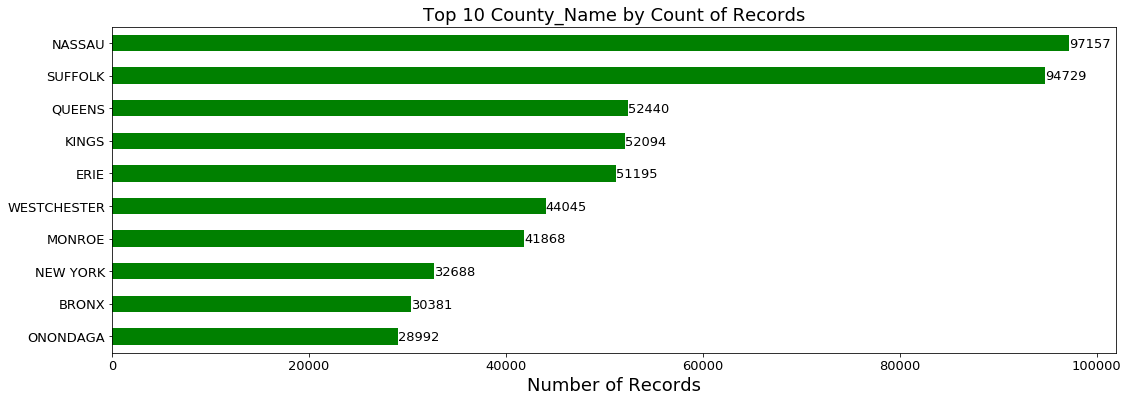

In [17]:
plt.figure(figsize=(18,6))
bar_number(df, "County_Name", large_n = 10)

Next we condsider the top 10 Counties by Percentage of Crashes Without a Police Report. Do this we use our cross_tab function which takes a dataframe, the names of 2 columns to be cross tabulated, and an indicator to define whether to return counts (0), percentages by column (1), or percentages by row (2). When selecting 1 or 2 it is the same as observed probability distribution.

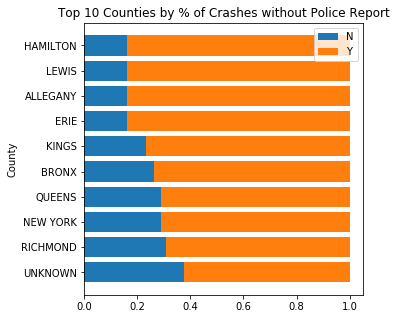

In [20]:
top10_county_noreport = cross_tab(df, 'County_Name', 'Police_Report', 2).sort_values( by = "N", ascending = False).head(10)

plt.figure(figsize=(5,5))
plt.title("Top 10 Counties by % of Crashes without Police Report")
plt.ylabel("County")
plot_bar(top10_county_noreport, vertical=False)

As can be seen by the graph above, Queens, New York, Kings, and Bronx are all Counties with a high count of car crashes and a high percentage of car crashes with no police report. Also as seen in the graph below these counties have a higher number of Injury Accidents.

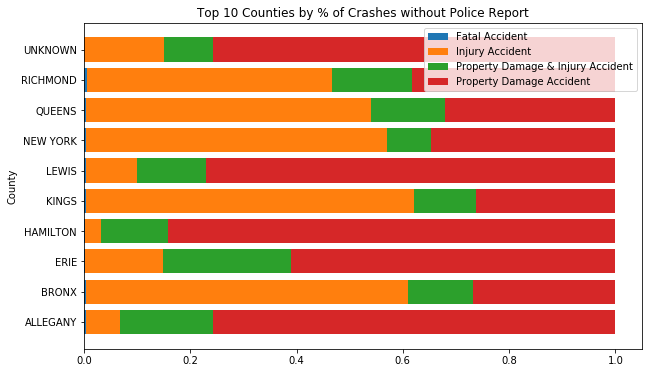

In [23]:
a = cross_tab(df,'County_Name','Crash_Descriptor',2 )
county_noreport_crash = a[a['County_Name'].isin(top10_county_noreport['County_Name'])]
plt.figure(figsize=(10,6))
plt.title("Top 10 Counties by % of Crashes without Police Report")
plt.ylabel("County")
plot_bar(county_noreport_crash, vertical=False)

To examine counties more wholistically, in the we compare the relationship of number of crashes per county to the following percentage variables:
1. Percent of Crashes Without a Police Report.
2. Percent of Crashes With Fatalities.
3. Percent of Crashes With Fatalities and/or Injuries.
4. Percent of Crashes Involving a Biker or Pedestrian.

Text(0.5, 1.0, 'Crashes involving pedestrian/biker by Count of Crashes Per County')

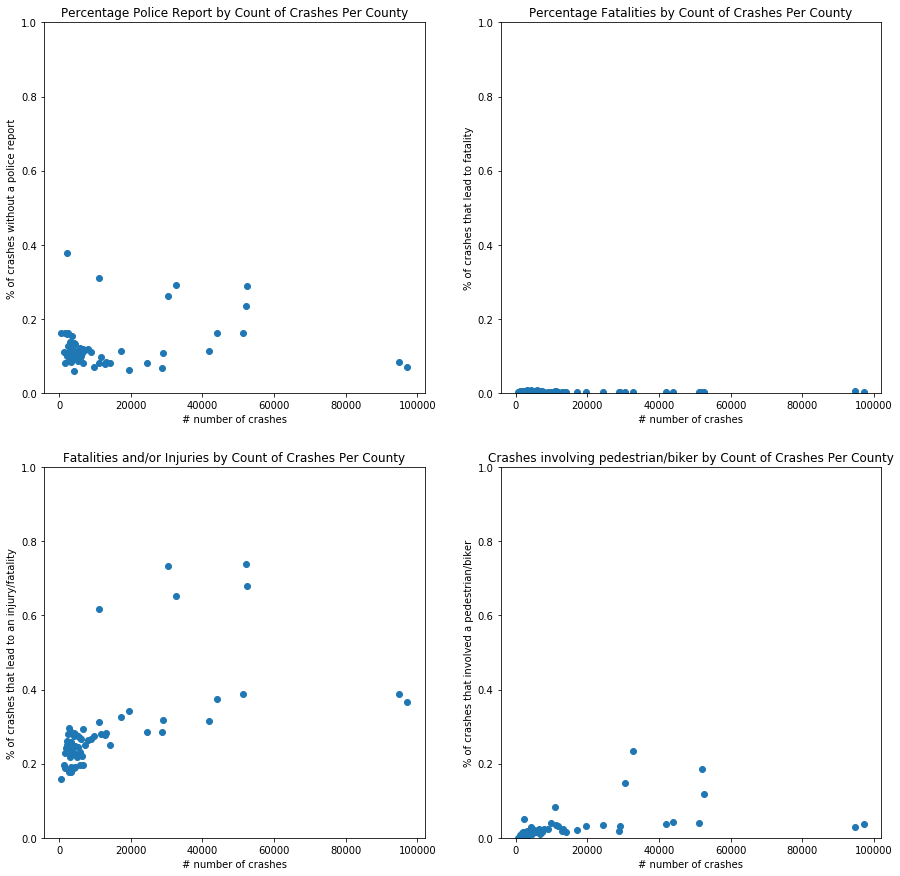

In [24]:
county_count = summary(df,'County_Name')
county_count = county_count.sort_values('County_Name')
county_count = county_count["count"]

no_police_report = cross_tab(df, 'County_Name', 'Police_Report', 2)
no_police_report = no_police_report.sort_values('County_Name')
no_police_report = no_police_report["N"]

fatal =  cross_tab(df, 'County_Name', 'Crash_Descriptor', 2)
fatal = fatal.sort_values('County_Name')
fatal = fatal["Fatal Accident"]


injury =  cross_tab(df, 'County_Name', 'Injury', 2)
injury = injury.sort_values('County_Name')
injury = injury[1] 


pedestrian_biker =  cross_tab(df, 'County_Name', 'Pedestrian_Biker', 2)
pedestrian_biker = pedestrian_biker.sort_values('County_Name')
pedestrian_biker = pedestrian_biker[1]

plt.figure(figsize=(15, 15))
plt.subplot(2,2,1)
plt.scatter(county_count, no_police_report)
plt.xlabel('# number of crashes')
plt.ylabel('% of crashes without a police report')
plt.ylim(0,1)
plt.title('Percentage Police Report by Count of Crashes Per County')

plt.subplot(2,2,2)
plt.scatter(county_count, fatal)
plt.xlabel('# number of crashes')
plt.ylabel('% of crashes that lead to fatality')
plt.ylim(0,1)
plt.title('Percentage Fatalities by Count of Crashes Per County')

plt.subplot(2,2,3)
plt.scatter(county_count, injury)
plt.xlabel('# number of crashes')
plt.ylabel('% of crashes that lead to an injury/fatality')
plt.ylim(0,1)
plt.title('Fatalities and/or Injuries by Count of Crashes Per County')

plt.subplot(2,2,4)
plt.scatter(county_count, pedestrian_biker)
plt.xlabel('# number of crashes')
plt.ylabel('% of crashes that involved a pedestrian/biker')
plt.ylim(0,1)
plt.title('Crashes involving pedestrian/biker by Count of Crashes Per County')

The first graph shows that there are county outliers with a high rate of no police report and low number of crashes, as well as county outliers with low rate of no police report and high number of crashes.

The relationship between number of crashes and fatlities is very flat. However when adding injury types to the percentage, as seen in the bottom left graph, the relationship appears to be much stronger. 

The bottom right graph also indicates that the relationship appears farily flat between % of crashes involving a pedestrian or biker except for a few outliers with an above average number of crashes. 

Finally, it is very interesting to note the 2 outliers by number crashes above 90K - Nassua and Suffolk County. These 2 counties though high in number of crashes are not effected by these percentage statistics.

# 3.2 Car Crash Time Variables In Relationship to Crash Type

The following crash types are observed in the data by count and percentage as seen below.

In [16]:
summary(df,'Crash_Descriptor')

,Crash_Descriptor,count,percent
0,Property Damage Accident,525828,0.603670
1,Injury Accident,173363,0.199027
2,Property Damage & Injury Accident,168921,0.193928
3,Fatal Accident,2940,0.003375


In phase 2 of our anaylysis, we examine car crashes in relationship to time variables and crash types. The below left graph shows the frequency of car crashes over the day of the week. Similarly, the below right graph shows  the observed probability distribution over the days of the week for each crash type. Notice, unlike the other types of crashes, the frequency of fatal crashes rises on the weekend.

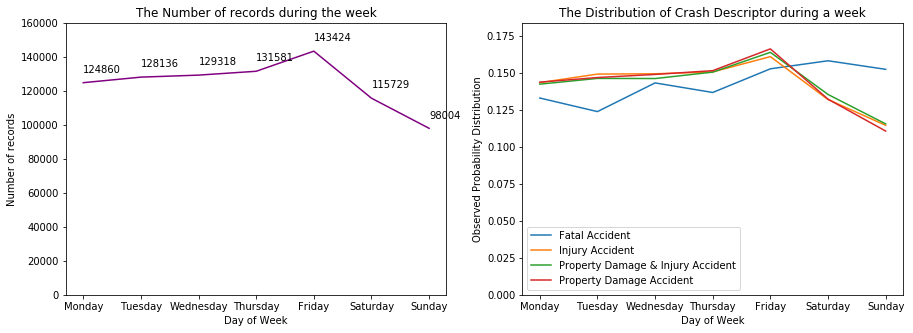

In [17]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
week = summary(df, "Day_of_Week")
plt.plot(week.Day_of_Week, week["count"], c = "purple")
for x,y in zip(week.Day_of_Week, week['count']):
    label = '{:}'.format(y)
    plt.annotate(label, (x,y), 
                 textcoords="offset points",
                 xytext=(0,10))
plt.ylim(0, 160000)
plt.title("The Number of records during the week")
plt.ylabel("Number of records")
plt.xlabel("Day of Week")

plt.subplot(1,2,2)
week_crash = cross_tab(df,'Day_of_Week', 'Crash_Descriptor', 1)
plt.title("The Distribution of Crash Descriptor during a week")
plt.xlabel("Day of Week")
plt.ylabel("Observed Probability Distribution")
plt.ylim(0,160000/df.shape[0])
plot_line(week_crash)

Further, we examine car crashes in relationship to hour of the day. The below left graph shows the frequency of car crashes over the hour of the day. Similarly, the below right graph shows  the observed probability distribution over the hour of the day by each car crash. Unlike the other types of crashes, the probability distribution for fatal car crashes is less influenced by the time of day.

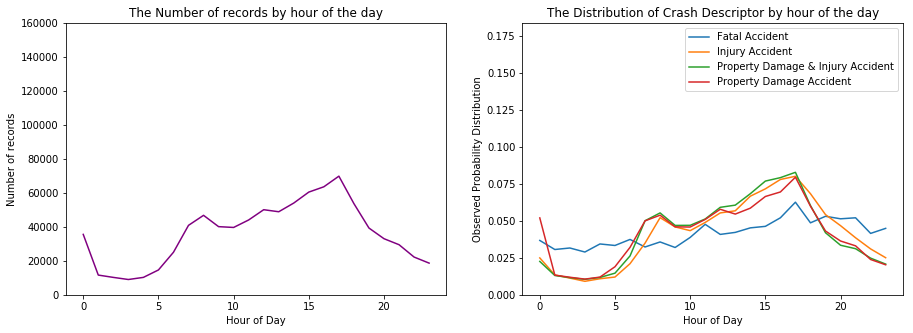

In [18]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
hour = summary(df, "Hour")
hour = hour.sort_values("Hour")
plt.plot(hour["Hour"], hour["count"], c = "purple")
# for x,y in zip(hour.Hour, hour['count']):
#     label = '{:}'.format(y)
#     plt.annotate(label, (x,y), 
#                  textcoords="offset points",
#                  xytext=(0,10))
plt.ylim(0, 160000)
plt.title("The Number of records by hour of the day")
plt.ylabel("Number of records")
plt.xlabel("Hour of Day")

plt.subplot(1,2,2)
hour_crash = cross_tab(df,'Hour', 'Crash_Descriptor', 1)
plt.title("The Distribution of Crash Descriptor by hour of the day")
plt.xlabel("Hour of Day")
plt.ylabel("Observed Probability Distribution")
plt.ylim(0,160000/df.shape[0])
plot_line(hour_crash)

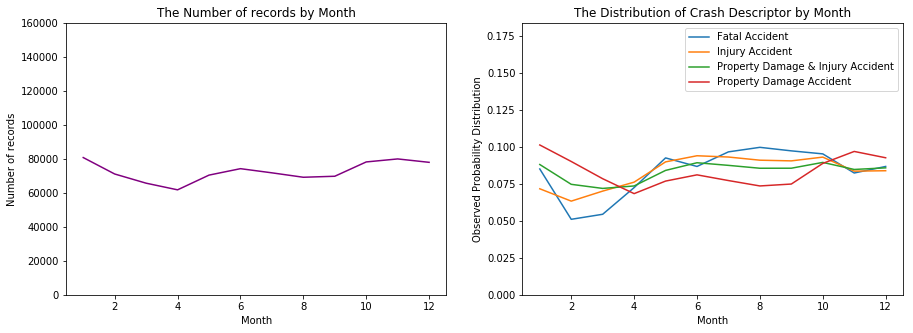

In [19]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
month = summary(df, "Month")
month = month.sort_values("Month")
plt.plot(month["Month"], month["count"], c = "purple")
# for x,y in zip(hour.Hour, hour['count']):
#     label = '{:}'.format(y)
#     plt.annotate(label, (x,y), 
#                  textcoords="offset points",
#                  xytext=(0,10))
plt.ylim(0, 160000)
plt.title("The Number of records by Month")
plt.ylabel("Number of records")
plt.xlabel("Month")

plt.subplot(1,2,2)
month_crash = cross_tab(df,'Month', 'Crash_Descriptor', 1)
plt.title("The Distribution of Crash Descriptor by Month")
plt.xlabel("Month")
plt.ylabel("Observed Probability Distribution")
plt.ylim(0,160000/df.shape[0])
plot_line(month_crash)

Finally, we examine car crashes in relationship to month of the year. The below left graph shows the frequency of car crashes over month. Similarly, the below right graph shows  the observed probability distribution over month for each crash type. Interestingly the property damage accidents (that do not involve injury) occur more often in the holidays (October to December).

# 3.2 Analysis on External Condition Variables of Car Crashes

Our last element of exploratory analysis is to examine the factors of external conditions on car crashes. This includes the followng variables:
1. Weather Conditions
2. Lighting Conditions
3. Road Descriptor

The below bar graphs show the count of crashes by these variables.

Text(0.5, 1.0, 'Count of Crashes by Road Descriptor')

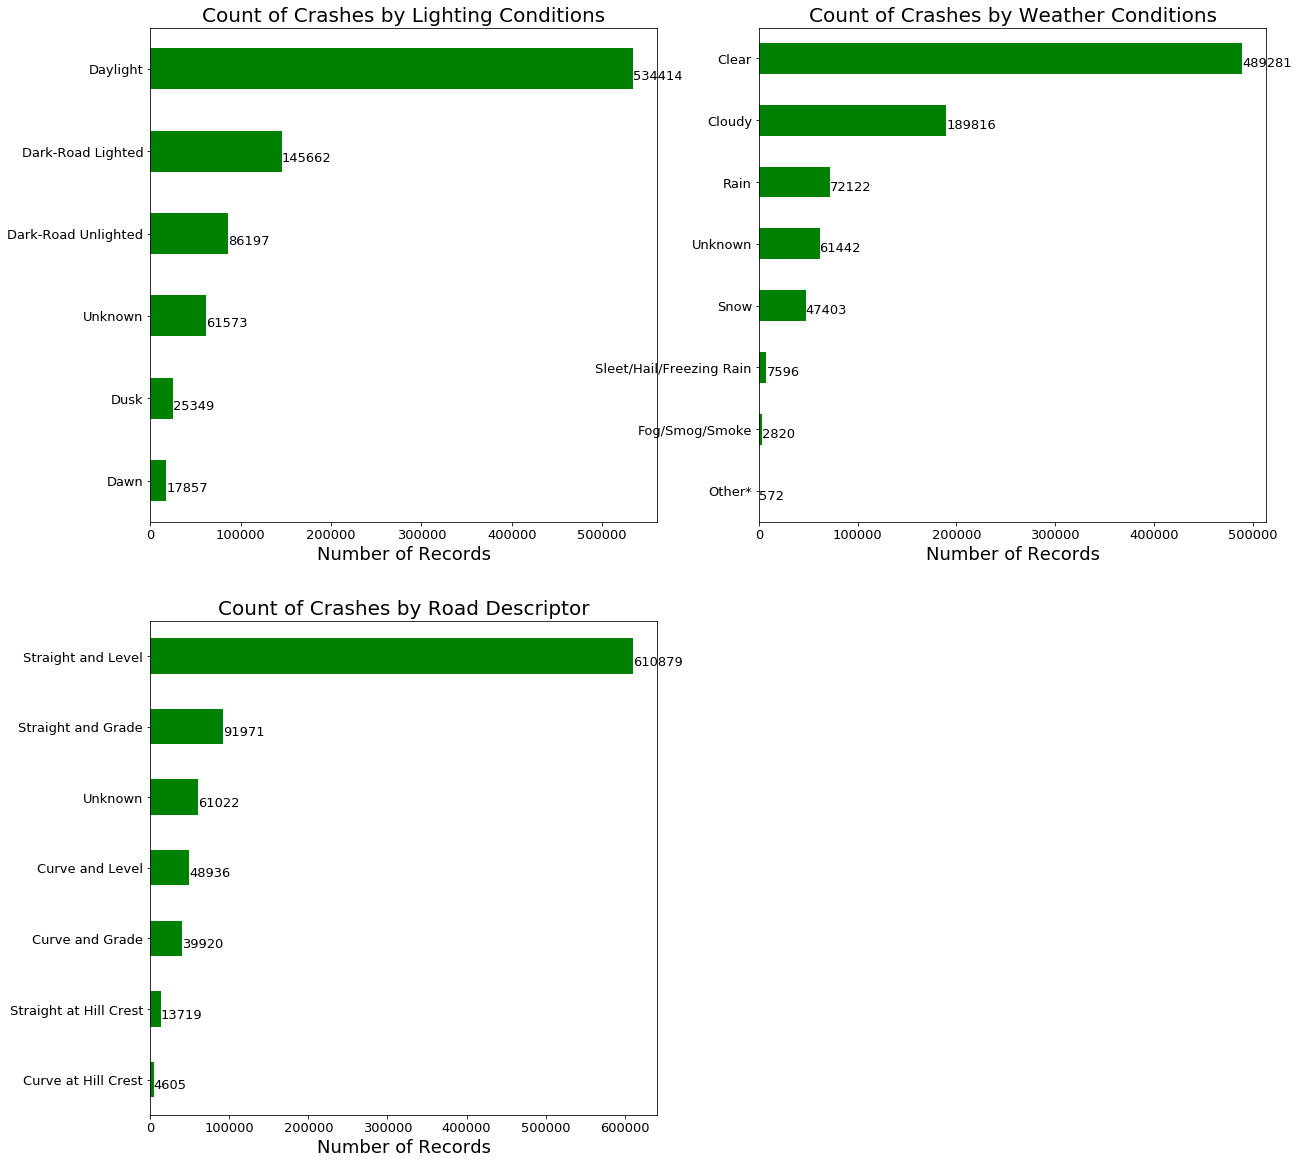

In [20]:
plt.figure(figsize=(20,20))

plt.subplot(2,2,1)
bar_number(df, 'Lighting_Conditions')
plt.title('Count of Crashes by Lighting Conditions', fontsize = 20)

plt.subplot(2,2,2)
bar_number(df, 'Weather_Conditions')
plt.title('Count of Crashes by Weather Conditions', fontsize = 20)

plt.subplot(2,2,3)
bar_number(df, 'Road_Descriptor')
plt.title('Count of Crashes by Road Descriptor', fontsize = 20)

In [42]:
a = df[['Lighting_Conditions','Weather_Conditions', 'Road_Descriptor']]
a['Lighting_Conditions'].value_counts()

Daylight               534414
Dark-Road Lighted      145662
Dark-Road Unlighted     86197
Unknown                 61573
Dusk                    25349
Dawn                    17857
Name: Lighting_Conditions, dtype: int64

In [43]:
a['Weather_Conditions'].value_counts()

Clear                       489281
Cloudy                      189816
Rain                         72122
Unknown                      61442
Snow                         47403
Sleet/Hail/Freezing Rain      7596
Fog/Smog/Smoke                2820
Other*                         572
Name: Weather_Conditions, dtype: int64

In [44]:
a['Road_Descriptor'].value_counts()

Straight and Level        610879
Straight and Grade         91971
Unknown                    61022
Curve and Level            48936
Curve and Grade            39920
Straight at Hill Crest     13719
Curve at Hill Crest         4605
Name: Road_Descriptor, dtype: int64

Text(0.5, 1.0, 'Count of Crashes by Lighting Conditions')

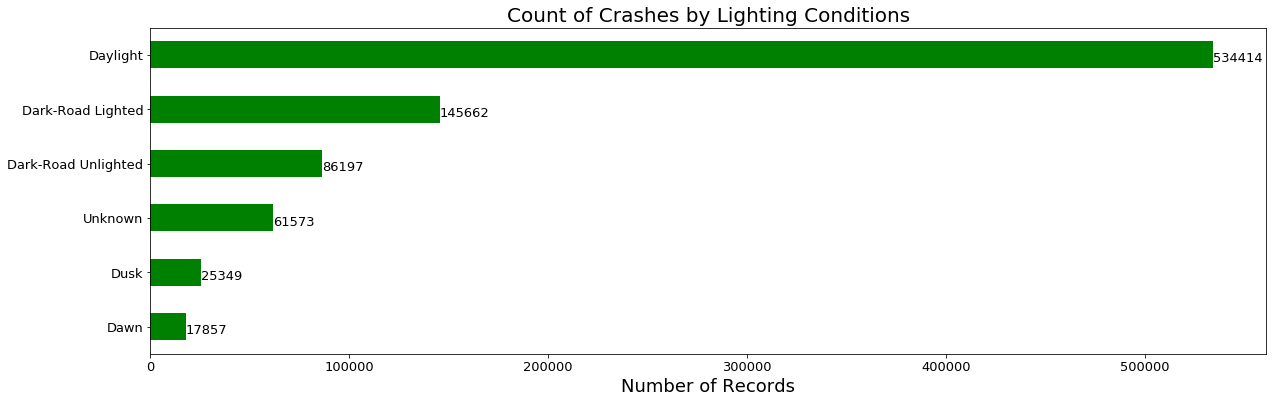

In [31]:
plt.figure(figsize=(20,6))

bar_number(df, 'Lighting_Conditions')
plt.title('Count of Crashes by Lighting Conditions', fontsize = 20)


Text(0.5, 1.0, 'Count of Crashes by Weather Conditions')

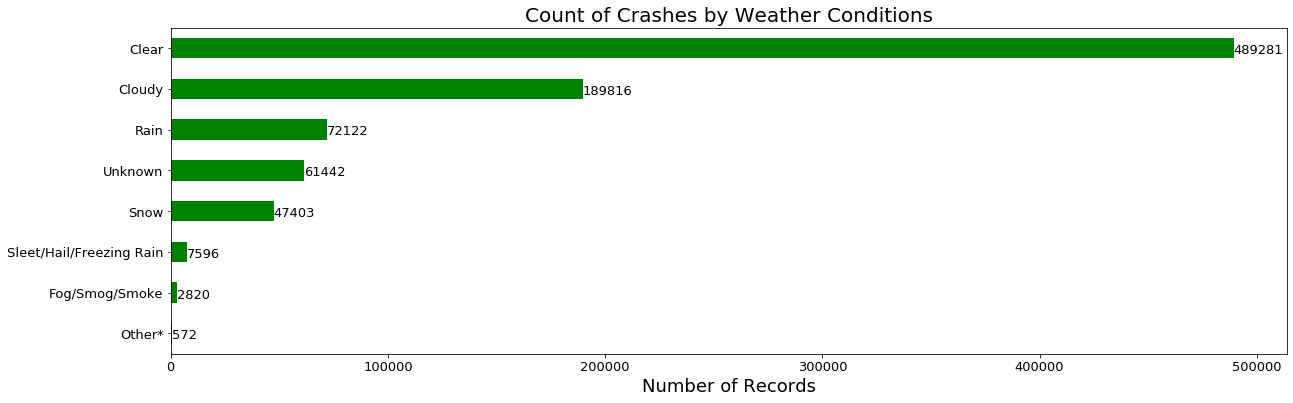

In [32]:
plt.figure(figsize=(20,6))
bar_number(df, 'Weather_Conditions')
plt.title('Count of Crashes by Weather Conditions', fontsize = 20)

Text(0.5, 1.0, 'Count of Crashes by Road Descriptor')

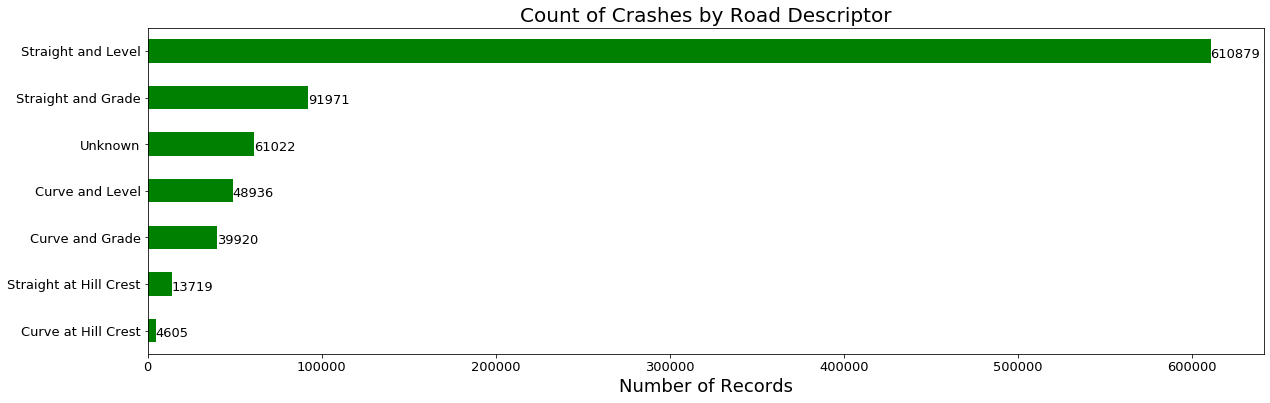

In [33]:
plt.figure(figsize=(20,6))
bar_number(df, 'Road_Descriptor')
plt.title('Count of Crashes by Road Descriptor', fontsize = 20)

Unexpectandly, the element in each category that would seem the safest (day light, clear weather, and straight/level road) have a high number of crashes.

# IV. RUN PREDICTION MODEL

For our predictive model, we will build a random forest model to predict whether or not a police report would be filled out for a given crash based on the following features:

* Crash_Descriptor
* Lighting_Conditions 
* Collision_Type_Descriptor
* County_Name
* Road_Descriptor
* Weather_Conditions
* Traffic_Control_Device 
* Event_Descriptor
* Day_of_Week
* Number_of_Vehicles_Involved
* Hour
* Month
* Pedestrian_Biker

The purpose of our model is to build a model that fits the data well and the use a feature importance function to best understand what features contribute to whether or not a police report is filled out a crash.


In [21]:
col = ["Crash_Descriptor", "Lighting_Conditions", 
        "Collision_Type_Descriptor", "County_Name", 
       "Road_Descriptor", "Weather_Conditions", 
       "Traffic_Control_Device", 
       "Pedestrian_Bicyclist_Action", "Event_Descriptor", 
       "Day_of_Week","Number_of_Vehicles_Involved", 
       "Hour", "Month","Police_Report" ]
data = df[col] 

We change all variables to type "category", for model input.

In [22]:
for i in range(data.shape[1]-4):
    data.iloc[:,i] = data.iloc[:,i].str.replace(" ", "_")
    data.iloc[:,i] = data.iloc[:,i].astype('category')
    data.iloc[:,i] = data.iloc[:,i].cat.codes

C:\Users\tring\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Then we split the data to train data, test data, train label, and test label.

In [23]:
X, y = data.drop("Police_Report", axis=1), data['Police_Report']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

We choose the **Random Forest** model to fit the data.

In [24]:
rf = RandomForestClassifier(n_estimators=20, random_state=40) 
# Fit the model on your training data.
rf.fit(X_train, y_train) 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=40, verbose=0, warm_start=False)

With Random Forest model, we can know the importance of each attribute.

In [25]:
importances = rf.feature_importances_
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
Road_Descriptor,0.207429
Lighting_Conditions,0.145213
Traffic_Control_Device,0.139078
Hour,0.117343
County_Name,0.091976
Weather_Conditions,0.082151
Month,0.070130
Day_of_Week,0.054477
Collision_Type_Descriptor,0.045389
Crash_Descriptor,0.021500


In [26]:
y_pred = rf.fit(X_train, y_train).predict(X_test)

In [27]:
print(f'The accuracy of the model is {round(sum(y_pred == y_test) / y_test.count(),4)}')

The accuracy of the model is 0.939


In [28]:
f1_soc = f1_score(y_test, y_pred, average='macro')
print(f'The F1 score of the model is {round(f1_soc,4)}')

The F1 socre of the model is 0.8582


# Conclusion

* Our final conclusion is that we were able to build a model with high accuracy and show the factors that most matter in predicting whether or not a police report was created for a crash. This information would be beneficial to both police departments for operation metrics as well as for insurance companies who might want to know the factors that cause there to no be a police report for a car crash when a claim is filed.

* The most imporant factor, road_descriptor, is suprising as it would not be expected that the way the road is designed would have predictive powere for predicting when a police report is not filled out. 

* Lighting conditions may be contributed to the time of day as Hour is also a highly important feature. It may be that at certain times of day, persons found in an accident, are less bothered to call for police when an accident occurs. 

* Finally, it is also interesting the Traffic_Control_Device is an important feature. Given that there are some variables such as "unknown" in this feature, this analysis would recommend for research to understand how traffic control factors into whether or not a police report is created at a crash.